In [1]:
#msf single channel

In [2]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageEnhance  

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, contrast_factor=5.0):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.contrast_factor = contrast_factor  # 

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(image_name)
        
        
        image = ImageEnhance.Contrast(image).enhance(self.contrast_factor)
        
        image = self.transform(image)
        return image


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = Autoencoder()

disease_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_MSF_disease_disease_MSF/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/single_msf_wt_wild_type_MSF/')


disease_dataset = CustomDataset(disease_path, contrast_factor=9.5)
wild_type_dataset = CustomDataset(wild_type_path, contrast_factor=4.5)

disease_dataloader = DataLoader(disease_dataset, batch_size=32, shuffle=True)
wild_type_dataloader = DataLoader(wild_type_dataset, batch_size=32, shuffle=True)

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    for batch in disease_dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}")

torch.save(model.state_dict(), 'trained_model_msf_con.pth')
print("Trained model saved to 'trained_model_msf_con.pth'")


Epoch [1/10] Loss: 0.0922
Epoch [2/10] Loss: 0.0513
Epoch [3/10] Loss: 0.0456
Epoch [4/10] Loss: 0.0468
Epoch [5/10] Loss: 0.0414
Epoch [6/10] Loss: 0.0396
Epoch [7/10] Loss: 0.0453
Epoch [8/10] Loss: 0.0393
Epoch [9/10] Loss: 0.0412
Epoch [10/10] Loss: 0.0327
Trained model saved to 'trained_model_msf_con.pth'


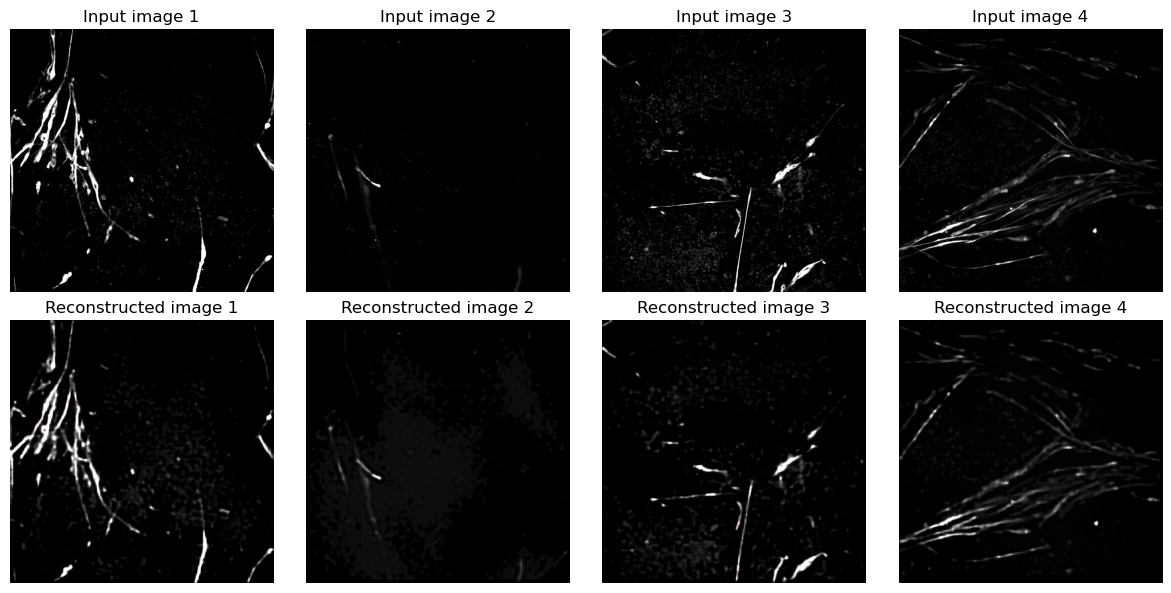

In [11]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageEnhance
import random
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance 


loaded_model = Autoencoder()
loaded_model.load_state_dict(torch.load('trained_model_msf_con.pth'))
loaded_model.eval()

def enhance_contrast(image, enhancement_factor=2):
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(enhancement_factor)
    return enhanced_image


path_list = [
    '/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_MSF_disease_disease_MSF/',
'/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/single_msf_wt_wild_type_MSF/'
]
selected_path = random.choice(path_list)

image_files = os.listdir(selected_path)
random_image_files = random.sample(image_files, 4)

plt.figure(figsize=(12, 6))
for i, image_file in enumerate(random_image_files, 1):
    input_image_path = os.path.join(selected_path, image_file)
    input_image = Image.open(input_image_path)
    input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)  

   
    with torch.no_grad():
        latent_vector = loaded_model.encoder(input_tensor)

    reconstructed_image = loaded_model.decoder(latent_vector)  

    input_pil_image = transforms.ToPILImage()(input_tensor.squeeze(0))
    reconstructed_pil_image = transforms.ToPILImage()(reconstructed_image.squeeze(0))

    enhanced_input_image = enhance_contrast(input_pil_image, enhancement_factor=15.5)
    enhanced_reconstructed_image = enhance_contrast(reconstructed_pil_image, enhancement_factor=15.5)

    plt.subplot(2, 4, i)
    plt.imshow(enhanced_input_image)
    plt.axis("off")
    plt.title(f"Input image {i}")

    plt.subplot(2, 4, i + 4)
    plt.imshow(enhanced_reconstructed_image)
    plt.axis("off")
    plt.title(f"Reconstructed image {i}")

plt.tight_layout()
plt.show()


In [12]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


class CustomDataset(Dataset):
    def __init__(self, data_dir, contrast_factor=5.0):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.contrast_factor = contrast_factor   

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(image_name)
        
       
        image = ImageEnhance.Contrast(image).enhance(self.contrast_factor)
        
        image = self.transform(image)
        return image


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = Autoencoder().to(device)
model.load_state_dict(torch.load('trained_model_msf_con.pth'))
model.eval()


disease_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_MSF_disease_disease_MSF/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/single_msf_wt_wild_type_MSF/')


def extract_latent_vectors(model, dataloader, num_samples=10):
    latent_vectors = []
    count = 0
    for batch in dataloader:
        if count >= num_samples:
            break
        batch = batch.to(device)
        with torch.no_grad():
            latent_vector = model.encoder(batch)
        latent_vectors.append(latent_vector)
        count += batch.size(0)
    return torch.cat(latent_vectors)


wild_type_dataset = CustomDataset(wild_type_path)
disease_dataset = CustomDataset(disease_path)


wild_type_dataloader = DataLoader(wild_type_dataset, batch_size=32, shuffle=True)
disease_dataloader = DataLoader(disease_dataset, batch_size=32, shuffle=True)


num_samples = 1000
wild_type_latent = extract_latent_vectors(model, wild_type_dataloader, num_samples)
disease_latent = extract_latent_vectors(model, disease_dataloader, num_samples)


wild_type_latent_flat = wild_type_latent.view(wild_type_latent.size(0), -1).cpu().numpy()
disease_latent_flat = disease_latent.view(disease_latent.size(0), -1).cpu().numpy()


combined_latent = np.vstack((wild_type_latent_flat, disease_latent_flat))

#pca
num_components = 9  
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(combined_latent)


wild_type_labels = np.zeros((wild_type_latent.size(0),))
disease_labels = np.ones((disease_latent.size(0),))
labels = np.concatenate((wild_type_labels, disease_labels))

In [14]:
mean_wt_latent = torch.mean(wild_type_latent, dim=0)  
mean_disease_latent = torch.mean(disease_latent, dim=0) 

distance = torch.norm(mean_wt_latent - mean_disease_latent)

print(f"Distance between mean wt and disease latent representations: {distance:.2f}")


Distance between mean wt and disease latent representations: 45.76
